Import and install neccesary libraries

In [5]:
# pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
import tkinter as tk
from tkinter import ttk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
import sys
import yfinance as yf
from PyQt5.QtWidgets import QApplication, QMainWindow, QLabel, QLineEdit, QPushButton, QVBoxLayout, QWidget

class StockDataApp(QMainWindow):
    def __init__(self):
        super().__init__()

        self.setWindowTitle("Stock Data Analysis")
        self.setGeometry(100, 100, 400, 200)

        self.central_widget = QWidget(self)
        self.setCentralWidget(self.central_widget)

        self.layout = QVBoxLayout()

        self.symbol_label = QLabel("Enter Stock Symbol:")
        self.layout.addWidget(self.symbol_label)

        self.symbol_input = QLineEdit()
        self.layout.addWidget(self.symbol_input)

        self.fetch_button = QPushButton("Fetch Data")
        self.fetch_button.clicked.connect(self.fetch_stock_data)
        self.layout.addWidget(self.fetch_button)

        self.central_widget.setLayout(self.layout)

    def fetch_stock_data(self):
        stock_symbol = self.symbol_input.text()
        stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
        # Process and display the data as needed

def main():
    app = QApplication(sys.argv)
    window = StockDataApp()
    window.show()
    sys.exit(app.exec_())

if __name__ == "__main__":
    start_date = "2023-01-01"
    end_date = "2023-08-01"
    main()


ModuleNotFoundError: No module named 'PyQt5'

Gather Historical Stock Data

In [6]:
# Function to fetch stock data
def fetch_stock_data(stock_symbol, start_date, end_date):
    stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
    return stock_data.dropna()

Calculate Daily Returns and Simple Moving Average (SMA) and Exponential Moving Average (EMA)

In [8]:
# Function to calculate daily returns
def calculate_daily_returns(stock_data):
    stock_data['Daily_Return'] = stock_data['Adj Close'].pct_change()
    stock_data = stock_data.dropna()  # Remove rows with NaN values
    return stock_data.dropna()

# Function to calculate Simple Moving Average (SMA) and Exponential Moving Average (EMA)
def calculate_sma_ema(stock_data, window):
    stock_data['SMA'] = stock_data['Close'].rolling(window=window).mean()
    stock_data['EMA'] = stock_data['Close'].ewm(span=window, adjust=False).mean()
    return stock_data.dropna()

Prepare Features and Target

In [9]:
def prepare_data(stock_data, num_days):
    X = []
    y = []
    for i in range(len(stock_data) - num_days):
        X.append(stock_data[['Daily_Return', 'SMA', 'EMA']].iloc[i:i+num_days])
        y.append(stock_data['Daily_Return'].iloc[i+num_days])
    return np.array(X), np.array(y)

Train and Evaluate Models

In [10]:
# Function to train and evaluate machine learning models
def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    models = {
        'Linear Regression': LinearRegression(),
        # Add more models as needed
    }
    
    best_model = None
    best_mse = float('inf')
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        
        if mse < best_mse:
            best_mse = mse
            best_model = model
    
    print(f"Best Model: {best_model}")
    print(f"Best MSE: {best_mse}")
    
    return best_model


Visualize Predictions

In [11]:
# Function to visualize predictions
def visualize_predictions(predicted_returns, date_labels):
    plt.figure(figsize=(10, 6))
    plt.plot(date_labels, predicted_returns, label='Predicted Returns', marker='o')
    plt.xlabel('Date')
    plt.ylabel('Predicted Returns')
    plt.title('Predicted Stock Returns')
    plt.legend()
    plt.grid(True)
    plt.show()

Main Function

[*********************100%***********************]  1 of 1 completed
Best Model: LinearRegression()
Best MSE: 9.407284971488239e-05
        Date  Predicted_Return
0 2023-08-01         -0.004002
1 2023-08-02          0.169871
2 2023-08-03          0.080643
3 2023-08-04          0.252016
4 2023-08-07          0.348281
5 2023-08-08          0.263642
6 2023-08-09          0.429905


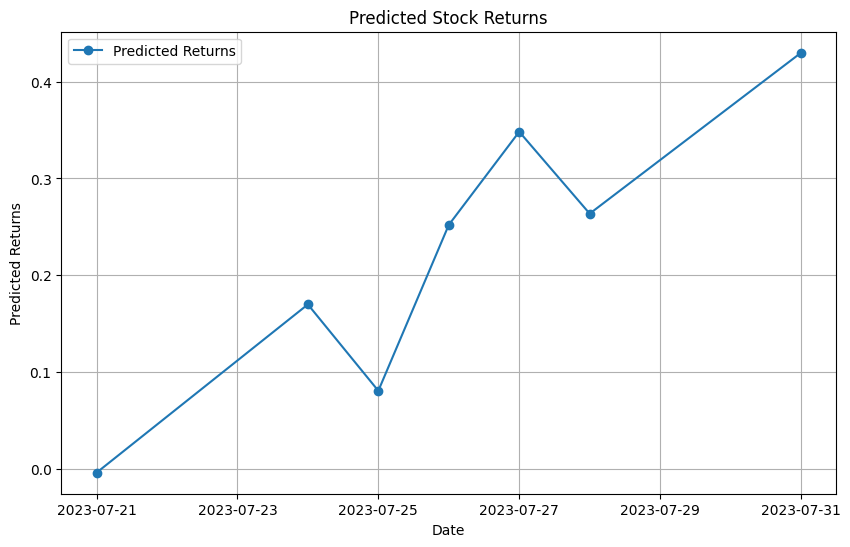

In [15]:
# Main Function
if __name__ == "__main__":
    stock_symbol = "AAPL"  # Replace with the stock symbol you're interested in
    start_date = "2023-01-01"
    end_date = "2023-08-01"
    num_days = 7  # Specify how many days in advance you want to predict
    
    stock_data = fetch_stock_data(stock_symbol, start_date, end_date)
    daily_returns_data = calculate_daily_returns(stock_data)
    
    # Choose the window size for SMA and EMA
    window = 20  # You can adjust this as needed
    
    stock_data = calculate_sma_ema(daily_returns_data, window)
    
    X, y = prepare_data(stock_data, num_days)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    best_model = train_and_evaluate_models(X_train, y_train, X_test, y_test)
    
    # Predict num_days in advance using the best model
    last_week_data = X_test[-1].reshape(1, -1)  # Take the last row of data
    
    predicted_returns = []
    
    for i in range(num_days):
        # Predict one day ahead
        prediction = best_model.predict(last_week_data)  # Predict one day
        predicted_returns.append(prediction[0])  # Append the prediction to the list
        
        # Update the last_week_data for the next prediction
        new_data_point = np.array([prediction[0], stock_data['SMA'].iloc[-num_days+i+1], stock_data['EMA'].iloc[-num_days+i+1]])
        last_week_data = np.roll(last_week_data, -3)  # Roll the array to remove the oldest day's data
        last_week_data[0, -3:] = new_data_point  # Append the new prediction data
    
    # Create a range of dates for the upcoming week
    prediction_dates = pd.date_range(start=end_date, periods=num_days, freq='B')
    date_labels = stock_data.index[-num_days:]
    
    # Create a DataFrame with dates and corresponding predicted returns
    prediction_df = pd.DataFrame({'Date': prediction_dates, 'Predicted_Return': predicted_returns})

    print(prediction_df)

    visualize_predictions(predicted_returns, date_labels)



Whole code at once

[*********************100%***********************]  1 of 1 completed
Best Model: LinearRegression()
Best MSE: 9.407289917805537e-05
        Date  Predicted_Return
0 2023-08-01         -0.004002
1 2023-08-02          0.169873
2 2023-08-03          0.080644
3 2023-08-04          0.252019
4 2023-08-07          0.348289
5 2023-08-08          0.263659
6 2023-08-09          0.429933


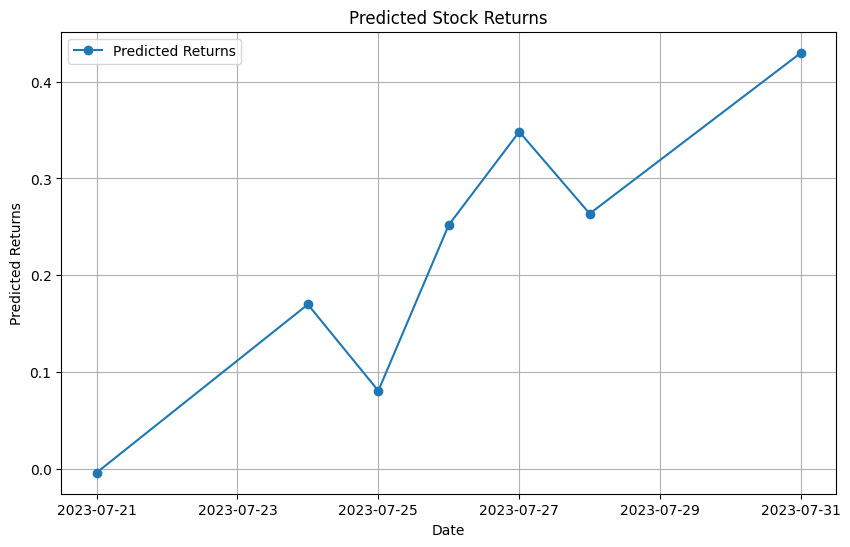

In [13]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Function to fetch stock data
def fetch_stock_data(stock_symbol, start_date, end_date):
    stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
    return stock_data.dropna()

# Function to calculate daily returns
def calculate_daily_returns(stock_data):
    stock_data['Daily_Return'] = stock_data['Adj Close'].pct_change()
    stock_data = stock_data.dropna()  # Remove rows with NaN values
    return stock_data.dropna()
# Function to calculate Simple Moving Average (SMA) and Exponential Moving Average (EMA)
def calculate_sma_ema(stock_data, window):
    stock_data['SMA'] = stock_data['Close'].rolling(window=window).mean()
    stock_data['EMA'] = stock_data['Close'].ewm(span=window, adjust=False).mean()
    return stock_data.dropna()

# Function to prepare the data
def prepare_data(stock_data, num_days):
    X = []
    y = []
    
    for i in range(len(stock_data) - num_days):
        X.append(stock_data[['Daily_Return', 'SMA', 'EMA']].iloc[i:i+num_days].values.flatten())
        y.append(stock_data['Daily_Return'].iloc[i+num_days])
           
    return np.array(X), np.array(y)

# Function to train and evaluate machine learning models
def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    models = {
        'Linear Regression': LinearRegression(),
        # Add more models as needed
    }
    
    best_model = None
    best_mse = float('inf')
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        
        if mse < best_mse:
            best_mse = mse
            best_model = model
            print(f"Best Model: {best_model}")
    print(f"Best MSE: {best_mse}")
    
    return best_model

# Function to visualize predictions
def visualize_predictions(predicted_returns, date_labels):
    plt.figure(figsize=(10, 6))
    plt.plot(date_labels, predicted_returns, label='Predicted Returns', marker='o')
    plt.xlabel('Date')
    plt.ylabel('Predicted Returns')
    plt.title('Predicted Stock Returns')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main Function
if __name__ == "__main__":
    stock_symbol = "AAPL"  # Replace with the stock symbol you're interested in
    start_date = "2023-01-01"
    end_date = "2023-08-01"
    num_days = 7  # Specify how many days in advance you want to predict
    stock_data = fetch_stock_data(stock_symbol, start_date, end_date)
    daily_returns_data = calculate_daily_returns(stock_data)
    
    # Choose the window size for SMA and EMA
    window = 20  # You can adjust this as needed
    
    stock_data = calculate_sma_ema(daily_returns_data, window)
    
    X, y = prepare_data(stock_data, num_days)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    best_model = train_and_evaluate_models(X_train, y_train, X_test, y_test)
    
    # Predict num_days in advance using the best model
    last_week_data = X_test[-1].reshape(1, -1)  # Take the last row of data
    
    predicted_returns = []
    
    for i in range(num_days):
        # Predict one day ahead
        prediction = best_model.predict(last_week_data)  # Predict one day
        predicted_returns.append(prediction[0])  # Append the prediction to the list
         # Update the last_week_data for the next prediction
        new_data_point = np.array([prediction[0], stock_data['SMA'].iloc[-num_days+i+1], stock_data['EMA'].iloc[-num_days+i+1]])
        last_week_data = np.roll(last_week_data, -3)  # Roll the array to remove the oldest day's data
        last_week_data[0, -3:] = new_data_point  # Append the new prediction data
    
    # Create a range of dates for the upcoming week
    prediction_dates = pd.date_range(start=end_date, periods=num_days, freq='B')
    date_labels = stock_data.index[-num_days:]
    
    # Create a DataFrame with dates and corresponding predicted returns
    prediction_df = pd.DataFrame({'Date': prediction_dates, 'Predicted_Return': predicted_returns})

    print(prediction_df)

    visualize_predictions(predicted_returns, date_labels)


User interface using Tkinter

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import ttk
import requests_cache  # Add this import - otherwise it would run for too long

# Enable caching
requests_cache.install_cache('stock_data_cache', expire_after=3600)  # Cache data for 1 hour

# Rest of your code (including functions) remains unchanged...


# Function to fetch stock data
def fetch_stock_data(stock_symbol, start_date, end_date):
    stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
    return stock_data.dropna()

# Function to calculate daily returns
def calculate_daily_returns(stock_data):
    stock_data['Daily_Return'] = stock_data['Adj Close'].pct_change()
    stock_data = stock_data.dropna()  # Remove rows with NaN values
    return stock_data.dropna()

# Function to calculate Simple Moving Average (SMA) and Exponential Moving Average (EMA)
def calculate_sma_ema(stock_data, window):
    stock_data['SMA'] = stock_data['Close'].rolling(window=window).mean()
    stock_data['EMA'] = stock_data['Close'].ewm(span=window, adjust=False).mean()
    return stock_data.dropna()

# Function to prepare the data
def prepare_data(stock_data, num_days):
    X = []
    y = []
    
    for i in range(len(stock_data) - num_days):
        X.append(stock_data[['Daily_Return', 'SMA', 'EMA']].iloc[i:i+num_days].values.flatten())
        y.append(stock_data['Daily_Return'].iloc[i+num_days])
    
    return np.array(X), np.array(y)

# Function to train and evaluate machine learning models
def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    models = {
        'Linear Regression': LinearRegression(),
        # Add more models as needed
    }
    
    best_model = None
    best_mse = float('inf')
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        
        if mse < best_mse:
            best_mse = mse
            best_model = model
    
    return best_model

# Function to visualize predictions
def visualize_predictions(predicted_returns, date_labels):
    plt.figure(figsize=(10, 6))
    plt.plot(date_labels, predicted_returns, label='Predicted Returns', marker='o')
    plt.xlabel('Date')
    plt.ylabel('Predicted Returns')
    plt.title('Predicted Stock Returns')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to predict stock returns
def predict_stock_returns():
    stock_symbol = stock_symbol_entry.get()
    start_date = "2023-01-01"
    end_date = "2023-08-01"
    num_days = 7  # Specify how many days in advance you want to predict
    
    stock_data = fetch_stock_data(stock_symbol, start_date, end_date)
    daily_returns_data = calculate_daily_returns(stock_data)
    
    # Choose the window size for SMA and EMA
    window = 20  # You can adjust this as needed
    
    stock_data = calculate_sma_ema(daily_returns_data, window)
    
    X, y = prepare_data(stock_data, num_days)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    best_model = train_and_evaluate_models(X_train, y_train, X_test, y_test)
    
    # Predict num_days in advance using the best model
    last_week_data = X_test[-1].reshape(1, -1)  # Take the last row of data
    
    predicted_returns = []
    
    for i in range(num_days):
        # Predict one day ahead
        prediction = best_model.predict(last_week_data)  # Predict one day
        predicted_returns.append(prediction[0])  # Append the prediction to the list
        
        # Update the last_week_data for the next prediction
        new_data_point = np.array([prediction[0], stock_data['SMA'].iloc[-num_days+i+1], stock_data['EMA'].iloc[-num_days+i+1]])
        last_week_data = np.roll(last_week_data, -3)  # Roll the array to remove the oldest day's data
        last_week_data[0, -3:] = new_data_point  # Append the new prediction data
    
    # Create a range of dates for the upcoming week
    prediction_dates = pd.date_range(start=end_date, periods=num_days, freq='B')
    date_labels = stock_data.index[-num_days:]
    
    # Create a DataFrame with dates and corresponding predicted returns
    prediction_df = pd.DataFrame({'Date': prediction_dates, 'Predicted_Return': predicted_returns})

    visualize_predictions(predicted_returns, date_labels)

# Create a Tkinter window
root = tk.Tk()
root.title("Stock Return Prediction")

# Create and place widgets in the window
frame = ttk.Frame(root)
frame.grid(column=0, row=0, padx=10, pady=10)

stock_symbol_label = ttk.Label(frame, text="Enter Stock Symbol:")
stock_symbol_label.grid(column=0, row=0, padx=5, pady=5)

stock_symbol_entry = ttk.Entry(frame)
stock_symbol_entry.grid(column=1, row=0, padx=5, pady=5)

predict_button = ttk.Button(frame, text="Predict Returns", command=predict_stock_returns)
predict_button.grid(column=2, row=0, padx=5, pady=5)

result_text = tk.Text(frame, height=10, width=40)
result_text.grid(column=0, row=1, columnspan=3, padx=5, pady=5)

# Start the Tkinter main loop
root.mainloop()


ModuleNotFoundError: No module named 'requests_cache'